In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import cv2
import json
import os
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import keras
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import optimizers
from keras import backend as K
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [ ]:
df_train_path = "/content/drive/MyDrive/Masters/deeplearning/project/Dataset/Train"
df_test_path = "/content/drive/MyDrive/Masters/deeplearning/project/Dataset/Test"
df_val_path = "/content/drive/MyDrive/Masters/deeplearning/project/Dataset/Validation"

In [ ]:
# Initialize number of classes and labels
NUM_CLASS, class_names = None, None
NUM_CLASS = 3
class_names = ['face_with_mask_incorrect', 'face_with_mask_correct', 'face_no_mask']
#class_names = ['face_with_mask', 'face_no_mask']

In [ ]:
LEARNING_RATE = 1e-4
EPOCHS = 20
BATCH_SIZE = 32
IMG_SIZE = 224
dataset_path = "/content/drive/MyDrive/Masters/deeplearning/project/Dataset/Train"
checkpoint_filepath = "/content/epoch-{epoch:02d}-val_acc-{val_accuracy:.4f}.h5"
model_save_path = "/content/drive/MyDrive/Masters/deeplearning/project/mask_detector_v2.h5"
figure_save_path = "/content/drive/MyDrive/Masters/deeplearning/project/fig.jpg"

print("Num of classes: " + str(NUM_CLASS))
print("Classes: " + str(class_names))
print("Dataset path: " + dataset_path)
print("Checkpoint: " + checkpoint_filepath)
print("Figure save path: " + figure_save_path)

Num of classes: 3
Classes: ['face_with_mask_incorrect', 'face_with_mask_correct', 'face_no_mask']
Dataset path: /content/drive/MyDrive/Masters/deeplearning/project/Dataset/Train
Checkpoint: /content/epoch-{epoch:02d}-val_acc-{val_accuracy:.4f}.h5
Figure save path: /content/drive/MyDrive/Masters/deeplearning/project/fig.jpg


In [ ]:
data_generator = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
    preprocessing_function=preprocess_input,
    validation_split=0.2)


# Set as training data
train_generator = data_generator.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    subset='training')

# Set as validation data
validation_generator = data_generator.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
    subset='validation')

# Set as test data
test_generator = data_generator.flow_from_directory(
    "/content/drive/MyDrive/Masters/deeplearning/project/Dataset/Test",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
    subset='training')

Found 9463 images belonging to 3 classes.
Found 2364 images belonging to 3 classes.
Found 3155 images belonging to 3 classes.


In [ ]:
# Load the pre-trained model and remove the head FC layer
base_model = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, 3)))

# Construct the head of the model that will be placed on top of the base model
head_model = base_model.output
head_model = AveragePooling2D(pool_size=(5, 5))(head_model)
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(128, activation="relu")(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(64, activation="relu")(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(NUM_CLASS, activation="softmax")(head_model)

# Place the head FC model on top of the base model (this will become the actual model we will train)
model = Model(inputs=base_model.input, outputs=head_model)

# Loop over all layers in the base model and freeze them so they will *not* be updated during the first training process
for layer in base_model.layers:
    layer.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
#model.summary()

In [ ]:
opt = Adam(lr=LEARNING_RATE)    
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
# Add early stopping criterion
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.0001,
    patience=3,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True)

# Add model checkpoint
checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=False,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='auto')

# Train the head of the network
print("[INFO] training head...")
H = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    callbacks=[early_stopping, checkpoint],
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=EPOCHS)

# Save best model
model.save(model_save_path)


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[INFO] training head...
Epoch 1/20
295/295 [==============================] - 3083s 10s/step - loss: 0.4547 - accuracy: 0.8212 - val_loss: 0.0958 - val_accuracy: 0.9739
Epoch 2/20
295/295 [==============================] - 532s 2s/step - loss: 0.1612 - accuracy: 0.9480 - val_loss: 0.0544 - val_accuracy: 0.9803
Epoch 3/20
295/295 [==============================] - 539s 2s/step - loss: 0.1159 - accuracy: 0.9618 - val_loss: 0.0537 - val_accuracy: 0.9824
Epoch 4/20
295/295 [==============================] - 536s 2s/step - loss: 0.0911 - accuracy: 0.9693 - val_loss: 0.0404 - val_accuracy: 0.9859
Epoch 5/20
295/295 [==============================] - 533s 2s/step - loss: 0.0773 - accuracy: 0.9759 - val_loss: 0.0431 - val_accuracy: 0.9833
Epoch 6/20
295/295 [==============================] - 527s 2s/step - loss: 0.0685 - accuracy: 0.9761 - val_loss: 0.0359 - val_accuracy: 0.9876
Epoch 7/20
295/295 [==============================] - 526s 2s/step - loss: 0.0577 - accuracy: 0.9789 - val_loss: 0.0

In [ ]:
# from keras.models import load_model
# model = load_model('/content/drive/MyDrive/Masters/deeplearning/project/mask_detector_v2.h5')

<ipython-input-12-6cdf5ad9eccf>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  prediction = model.predict_generator(


74/74 [==============================] - 786s 11s/step
Classification Report:
                          precision    recall  f1-score   support

face_with_mask_incorrect       1.00      1.00      1.00       716
  face_with_mask_correct       0.99      0.98      0.98       822
            face_no_mask       0.98      0.99      0.99       826

                accuracy                           0.99      2364
               macro avg       0.99      0.99      0.99      2364
            weighted avg       0.99      0.99      0.99      2364

[[715   0   1]
 [  3 807  12]
 [  0  11 815]]


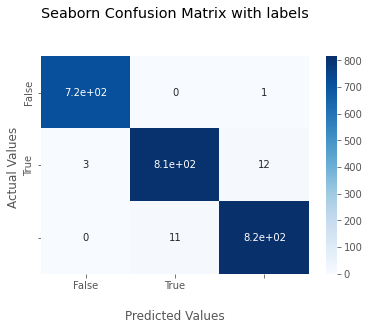

In [ ]:
# Create classification report
prediction = model.predict_generator(
    generator=validation_generator,
    verbose=1)
y_pred = np.argmax(prediction, axis=1)
print("Classification Report:")
print(classification_report(validation_generator.classes, y_pred, target_names=class_names))

#Generate the confusion matrix
cf_matrix = confusion_matrix(validation_generator.classes, y_pred)
print(cf_matrix)


import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
# Create classification report
prediction = model.predict_generator(
    generator=test_generator,
    verbose=1)
y_pred = np.argmax(prediction, axis=1)
print("Classification Report:")
print(classification_report(test_generator.classes, y_pred, target_names=class_names))

<ipython-input-14-1488ea9c8d4d>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  prediction = model.predict_generator(


99/99 [==============================] - 150s 1s/step
Classification Report:
                          precision    recall  f1-score   support

face_with_mask_incorrect       1.00      1.00      1.00       956
  face_with_mask_correct       0.98      0.99      0.99      1097
            face_no_mask       0.99      0.99      0.99      1102

                accuracy                           0.99      3155
               macro avg       0.99      0.99      0.99      3155
            weighted avg       0.99      0.99      0.99      3155



[[ 955    1    0]
 [   4 1084    9]
 [   0   16 1086]]


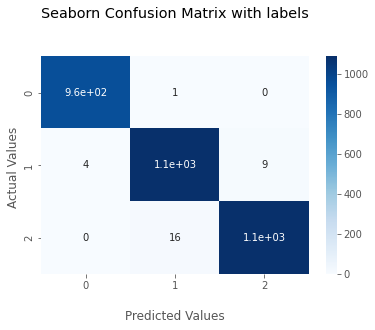

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(test_generator.classes, y_pred)

print(cf_matrix)

import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
# ax.xaxis.set_ticklabels(class_names)
# ax.yaxis.set_ticklabels(class_names)

## Display the visualization of the Confusion Matrix.
plt.show()

<ipython-input-17-6e66fb6463ac>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  prediction = model.predict_generator(


25/25 [==============================] - 35s 1s/step
Classification Report:
                          precision    recall  f1-score   support

face_with_mask_incorrect       1.00      1.00      1.00       238
  face_with_mask_correct       0.97      0.99      0.98       274
            face_no_mask       0.99      0.97      0.98       275

                accuracy                           0.99       787
               macro avg       0.99      0.99      0.99       787
            weighted avg       0.99      0.99      0.99       787



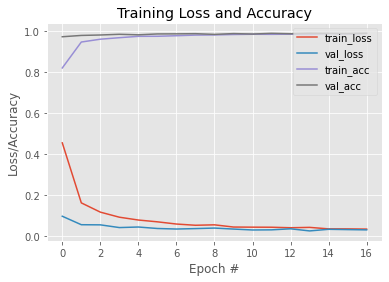

In [ ]:
# Create classification report
prediction = model.predict_generator(
    generator=test_generator,
    verbose=1)
y_pred = np.argmax(prediction, axis=1)
print("Classification Report:")
print(classification_report(test_generator.classes, y_pred, target_names=class_names))

# Plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, len(H.history["loss"])), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, len(H.history["val_loss"])), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, len(H.history["accuracy"])), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, len(H.history["val_accuracy"])), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")
plt.savefig(figure_save_path)